In [1]:
import numpy as np
import pandas as pd
#Visualization
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight') # use style fivethirtyeight
import seaborn as sns
from matplotlib import rcParams
import warnings 
warnings.filterwarnings("ignore")
# Scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# Selection
from scipy.stats import chi2_contingency
# Splitting the data into Train and Test
from sklearn.model_selection import train_test_split
# Algorithm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
# Evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix
# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [2]:
df = pd.read_csv('shipments.csv')

In [3]:
#Rename column target
df.rename(columns={'Reached.on.Time_Y.N':'is_late'}, inplace=True)
df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,is_late
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [4]:
df.shape

(10999, 12)

In [5]:
df.columns

Index(['ID', 'Warehouse_block', 'Mode_of_Shipment', 'Customer_care_calls',
       'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases',
       'Product_importance', 'Gender', 'Discount_offered', 'Weight_in_gms',
       'is_late'],
      dtype='object')

In [7]:
#Change all column names to lower case
df.columns = df.columns.str.lower()

In [9]:
#Get dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   10999 non-null  int64 
 1   warehouse_block      10999 non-null  object
 2   mode_of_shipment     10999 non-null  object
 3   customer_care_calls  10999 non-null  int64 
 4   customer_rating      10999 non-null  int64 
 5   cost_of_the_product  10999 non-null  int64 
 6   prior_purchases      10999 non-null  int64 
 7   product_importance   10999 non-null  object
 8   gender               10999 non-null  object
 9   discount_offered     10999 non-null  int64 
 10  weight_in_gms        10999 non-null  int64 
 11  is_late              10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


* Based on the information above :

1. Dataframe has 10999 rows and 12 columns.
2. No missing values are found.
3. There are only 2 data types, integer and object.
4. Classification target is_late and others we call features.

In [10]:
#Separate numeric & categorical column
# Categorical data
categorical = ['warehouse_block','mode_of_shipment','product_importance', 'gender', 'is_late', 'customer_rating']
# Numerical data
numeric = ['customer_care_calls', 'cost_of_the_product', 'prior_purchases', 'discount_offered', 'weight_in_gms']

In [11]:
# Data Cleansing & Feature Engineering
# Reload dataset
df_dt = df.copy()

In [12]:
#Identify missing values
df_dt.isna().values.any() # Missing value detection

False

In [13]:
df_dt.isna().sum()  # Calculate missing values

id                     0
warehouse_block        0
mode_of_shipment       0
customer_care_calls    0
customer_rating        0
cost_of_the_product    0
prior_purchases        0
product_importance     0
gender                 0
discount_offered       0
weight_in_gms          0
is_late                0
dtype: int64

* Just for making sure that no missing values are found.

In [14]:
# Identify duplicated values
# Select all duplicate rows based on all columns
df_dt[df_dt.duplicated(keep=False)] 

,id,warehouse_block,mode_of_shipment,customer_care_calls,customer_rating,cost_of_the_product,prior_purchases,product_importance,gender,discount_offered,weight_in_gms,is_late


In [15]:
# # Select all duplicate rows based on selected column
df_dt[df_dt.duplicated(subset=['id'],keep=False)] # Display all duplicated rows based on column 'id'

,id,warehouse_block,mode_of_shipment,customer_care_calls,customer_rating,cost_of_the_product,prior_purchases,product_importance,gender,discount_offered,weight_in_gms,is_late


* Luckily, there is no duplicated value in the dataframe.

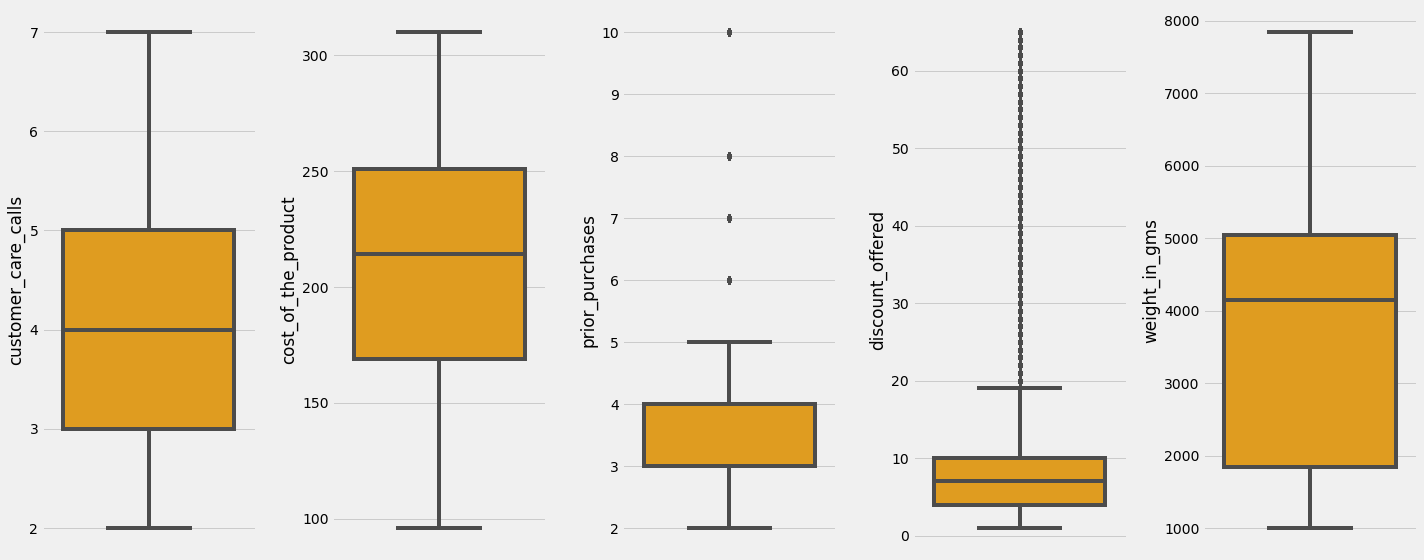

In [19]:
# Identify outliers
# Identify using boxplot
plt.figure(figsize=(20,8))
for i in range(0,len(numeric)):
    plt.subplot(1, len(numeric), i+1)
    sns.boxplot(y=df_dt[numeric[i]], color='orange')
    plt.tight_layout()

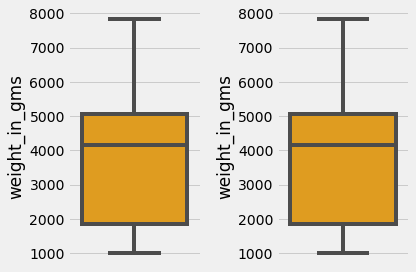

In [20]:
# Visualize after handle outlier
for i in range(0, len(['prior_purchases', 'discount_offered'])):
               plt.subplot(1,2, i+1)
               sns.boxplot(y= df_dt[col], color = 'orange', orient = 'v');
               plt.tight_layout();

* We didn't remove the outliers, but replacing with upper bound and lower bound. And we can see in the visualization above, there is no outliers detected.

In [21]:
#Feature Encoding : One hot encoding
# one hot encoding feature product_importance and keep high category
onehots = pd.get_dummies(df_dt['product_importance'], prefix = 'product_importance')
df_dt = df_dt.join(onehots)
# drop all categorical columns & 'id, except product_importance_high
df_dt.drop(columns=['warehouse_block','gender','mode_of_shipment',
                   'product_importance', 'product_importance_low',
                   'product_importance_medium','id'], inplace = True)
# check dataframe after encoding
df_dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   customer_care_calls      10999 non-null  int64
 1   customer_rating          10999 non-null  int64
 2   cost_of_the_product      10999 non-null  int64
 3   prior_purchases          10999 non-null  int64
 4   discount_offered         10999 non-null  int64
 5   weight_in_gms            10999 non-null  int64
 6   is_late                  10999 non-null  int64
 7   product_importance_high  10999 non-null  uint8
dtypes: int64(7), uint8(1)
memory usage: 612.4 KB


# Exploratory Data Analysis (EDA)

In [22]:
# Copy dataset
df_eda = df.copy()

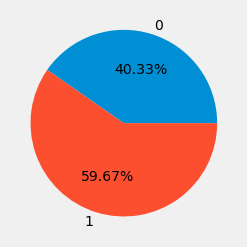

In [24]:
#Target Visualization
delay = pd.DataFrame(df_eda.groupby(['is_late'])['id'].count()/len(df_eda)).reset_index()
plt.pie(delay['id'],labels=delay['is_late'],autopct='%.2f%%');

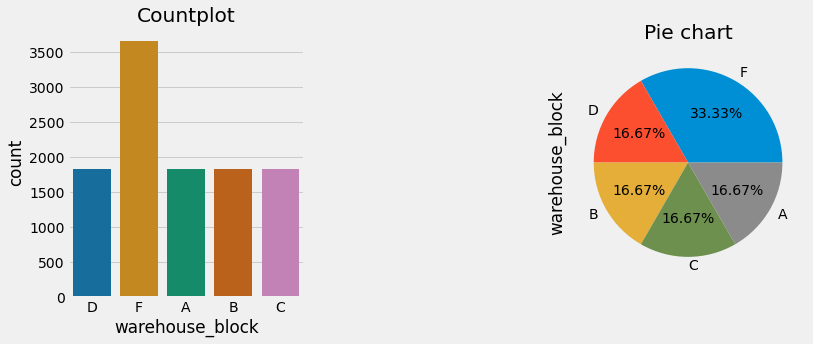

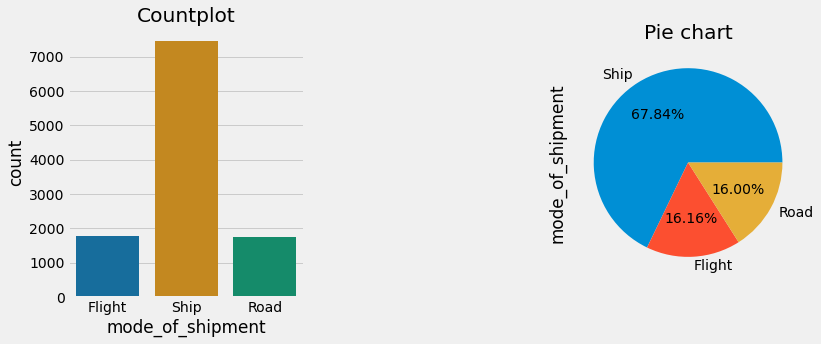

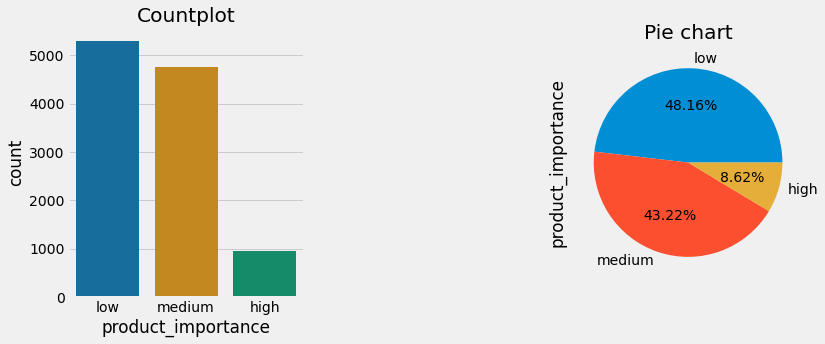

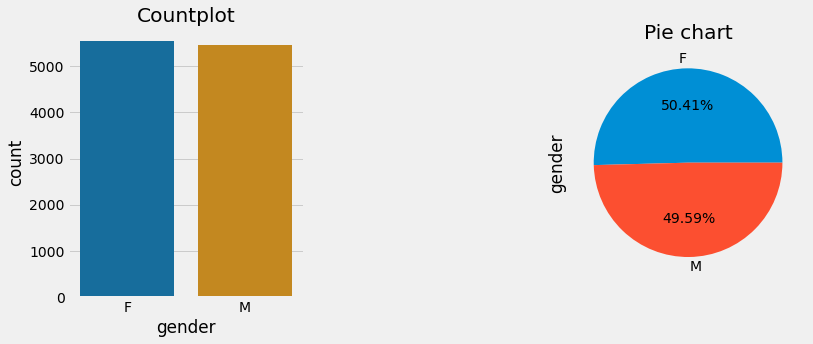

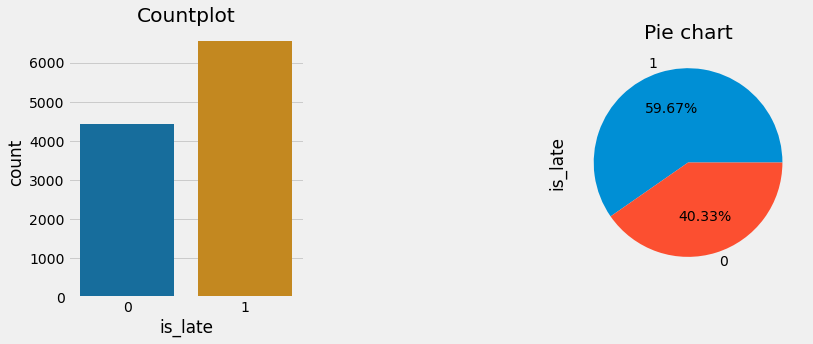

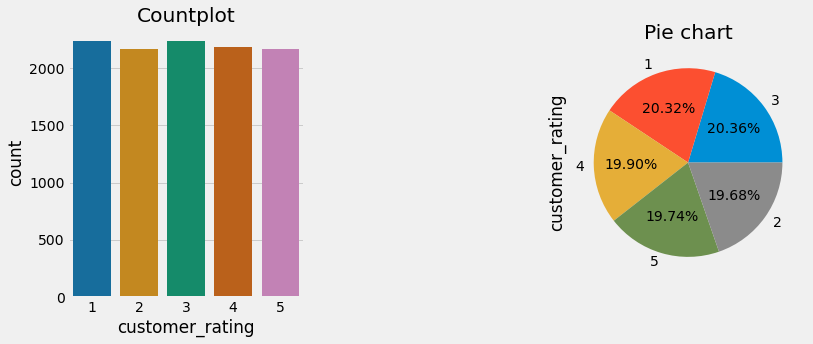

In [25]:
# Plot categorical columns
for col in categorical:
    plt.figure(figsize=(15, 5))
    
    plt.subplot(141);
    sns.countplot(df_eda[col], palette = 'colorblind', orient='v');
    plt.title('Countplot')
    plt.tight_layout();
    
    
    plt.subplot(143);
    df_eda[col].value_counts().plot.pie(autopct='%1.2f%%');
    plt.title('Pie chart')

* Summary :

1. Warehouse_Block has 5 unique values and dominated with Warehouse_block_f.
2. Mode_of_Shipment has 3 unique values and mostly used ship.
3. Product_importance has 3 unique values and mostly priority of products are low.
4. Female customers are often shopping than male.

In [27]:
# Numeric values
df_eda[numeric].describe()

,customer_care_calls,cost_of_the_product,prior_purchases,discount_offered,weight_in_gms
count,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,4.054459,210.196836,3.567597,13.373216,3634.016729
std,1.141490,48.063272,1.522860,16.205527,1635.377251
min,2.000000,96.000000,2.000000,1.000000,1001.000000
25%,3.000000,169.000000,3.000000,4.000000,1839.500000
50%,4.000000,214.000000,3.000000,7.000000,4149.000000
75%,5.000000,251.000000,4.000000,10.000000,5050.000000
max,7.000000,310.000000,10.000000,65.000000,7846.000000


* Summary :

  Distribution of customer_care_calls, Customer_rating, Cost_of_the_Product, Prior_purchases look normal, beacuse the mean and   the median are close, while discount_offered and weight_in_grams are indicated skewed.

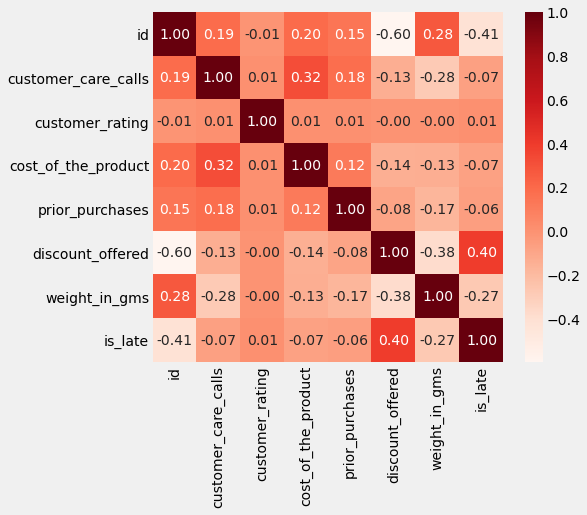

In [28]:
# Correlation Heatmap
plt.figure(figsize=(7,6));
sns.heatmap(df_eda.corr(), annot = True, fmt = '.2f', cmap = 'Reds');

* Based on the Correlation heatmap above :

  Target is_late has a moderate positive correlation with discount_offered & weak negative correlation with weight_in_gms.
  Feature customer_care_calss has a weak positive correlation with cost_of_the_product and negative correlation with        weight_in_gms.
  Feature discount_offered has a moderate negative correlation with weight_in_gms.

<Figure size 360x360 with 0 Axes>

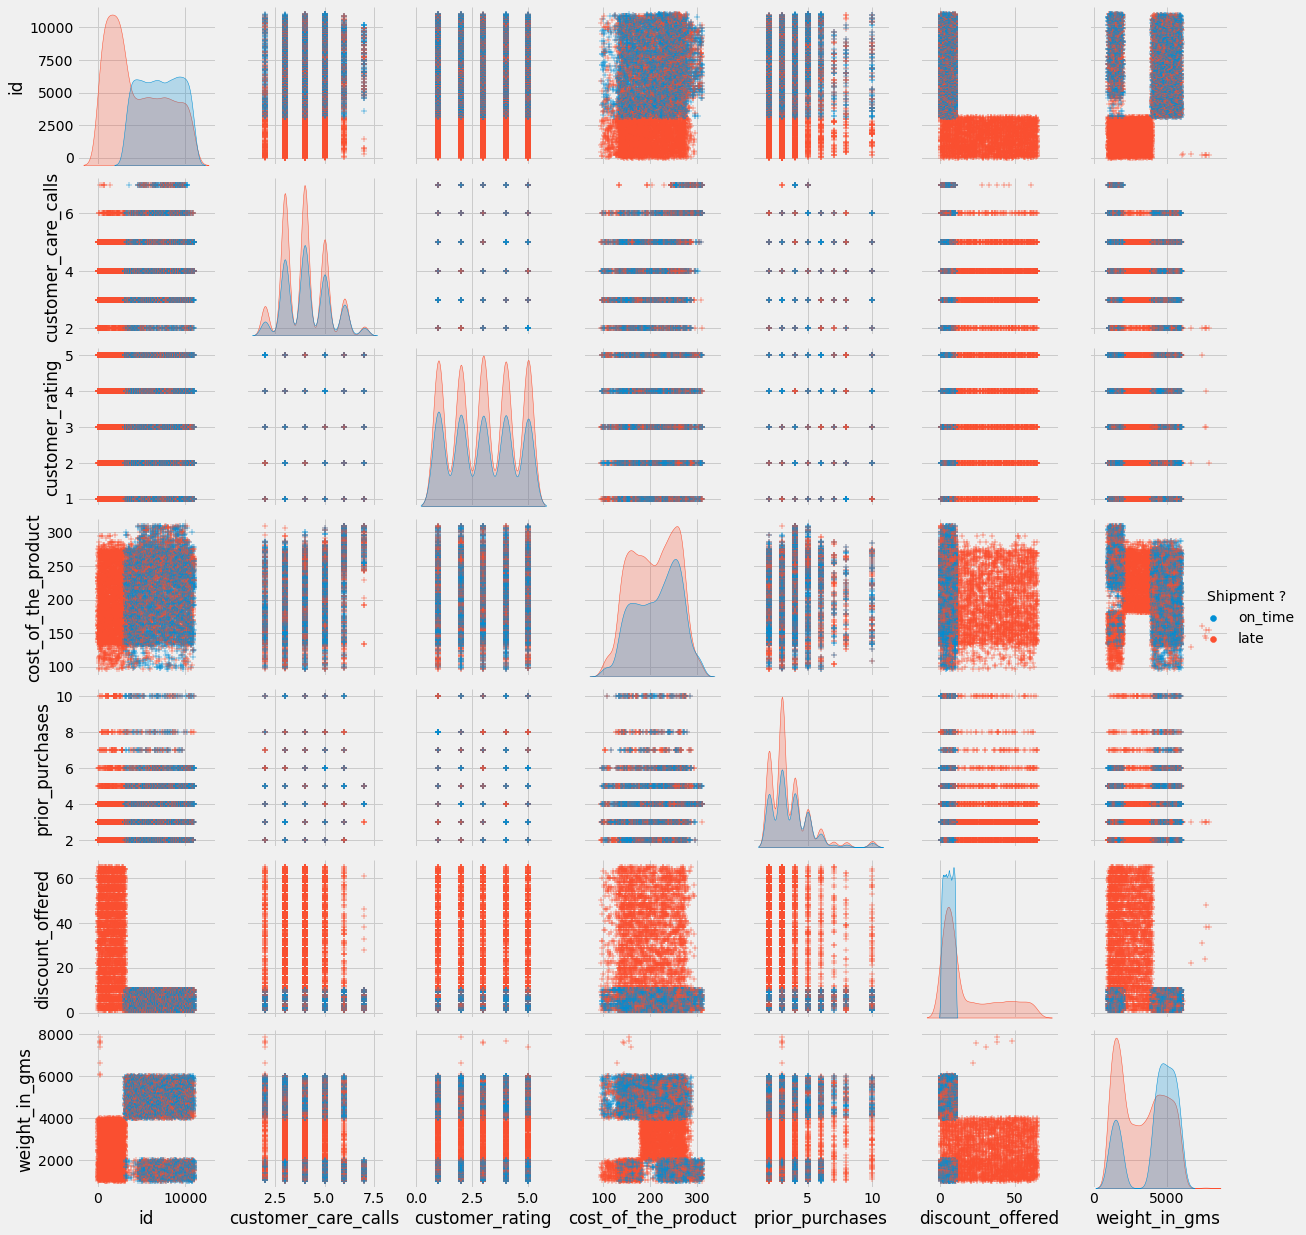

In [29]:
# Pairplot
plt.figure(figsize=(5, 5));
p = sns.pairplot(df_eda, markers = '+', diag_kind = 'kde', hue = 'is_late');
# title
new_title = 'Shipment ?'
p._legend.set_title(new_title);

# replace labels
new_labels = ['on_time', 'late']
for t, l in zip(p._legend.texts, new_labels): t.set_text(l);

* Summary :

1. The shipment tends to deliver on time when the discount under 10% and weight is 1 - 2 Kg & 4 - 6 Kg.
2. Most of products that cost around $300 delivered on time, others late.
3. Majority customers who get the late parcels are more likely to call customer care, no matter how often they called.

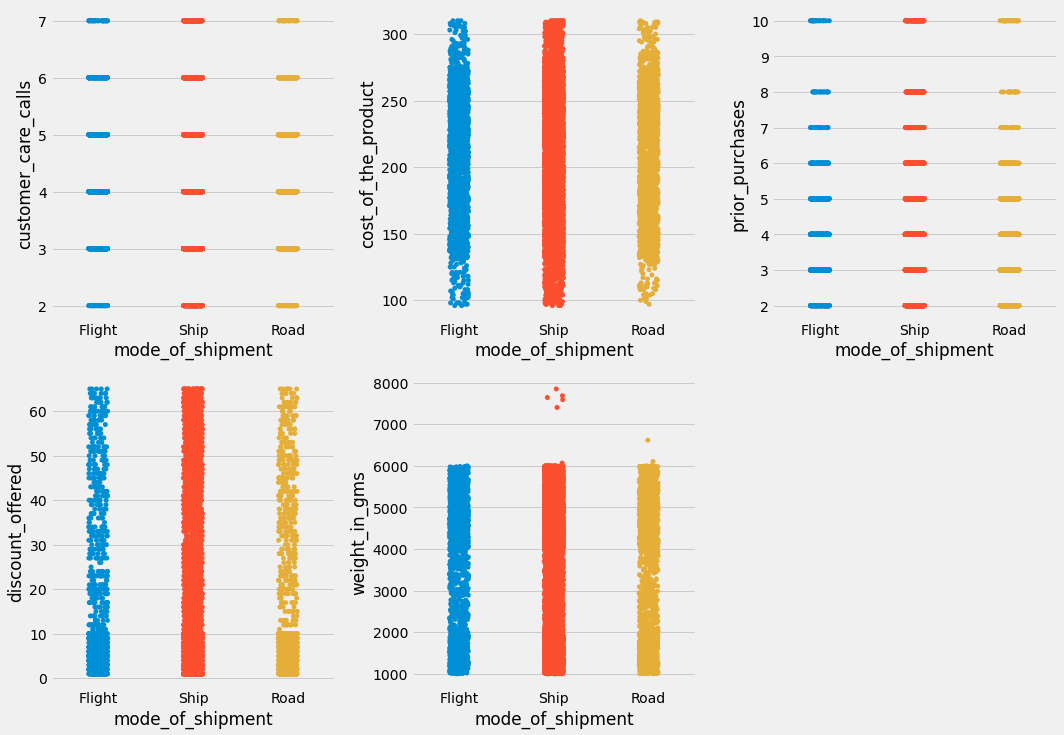

In [31]:
# Numeric - Mode of Shipment
fig = plt.figure(figsize=(15, 15))
for i in range(0, len(numeric)): # untuk setiap kolom numerik
    ax = fig.add_subplot(3, 3, i+1) # kita set posisi catplot/stripplotnya di layout
    sns.stripplot(ax=ax, data=df_eda, x='mode_of_shipment', y=numeric[i]) # gambar catplot/stripplotnya
    plt.tight_layout() # layout

    if i != 0: plt.close(i+1) # close figure 

    plt.close(len(numeric) + 1) # close figure 

* Summary :
Some parcels with the weight more than 6 Kg are delivered with ship & road. The ship can afford to carry the big parcels

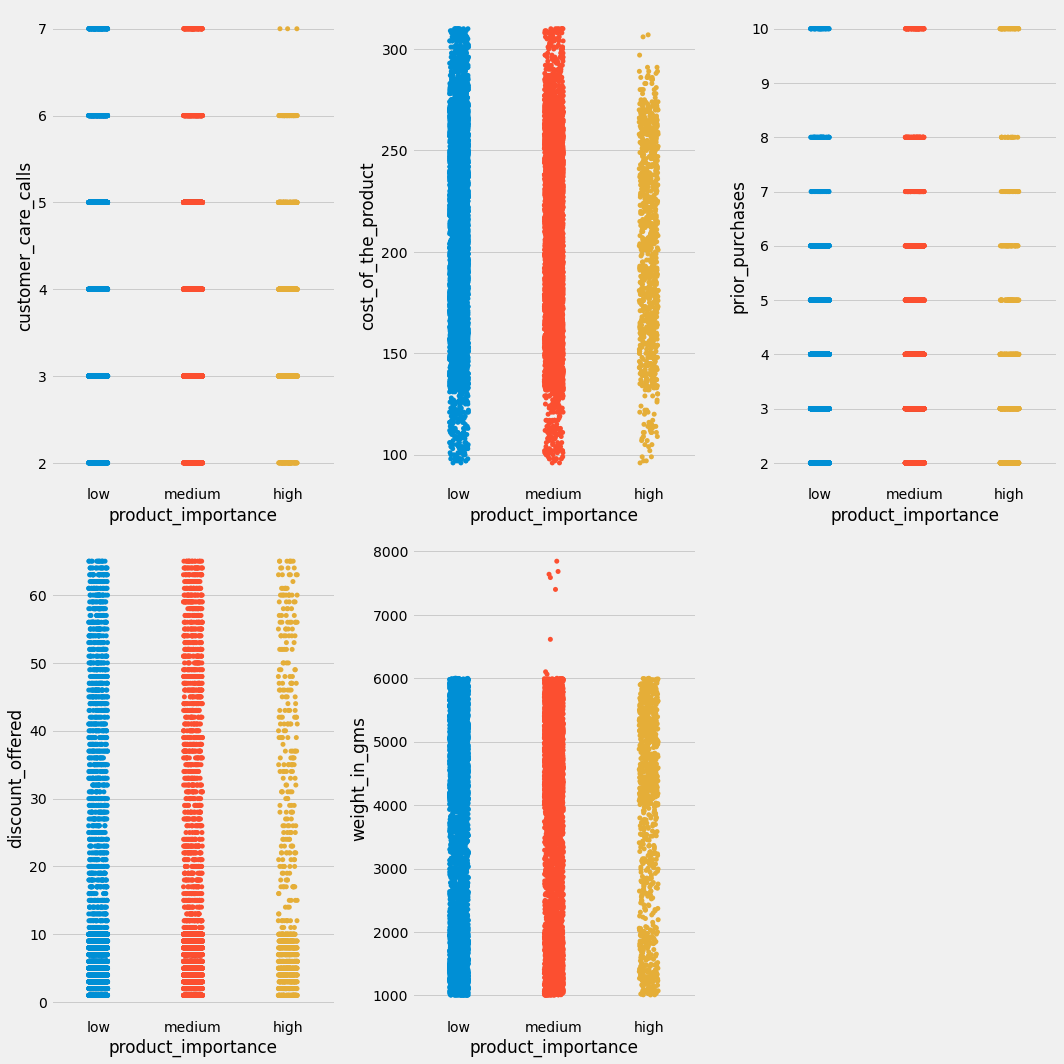

In [32]:
# Numeric - Product Importance
fig = plt.figure(figsize=(15, 15))
for i in range(0, len(numeric)): # untuk setiap kolom numerik
    ax = fig.add_subplot(2, 3, i+1) # kita set posisi catplot/stripplotnya di layout
    sns.stripplot(ax=ax, data=df_eda, x='product_importance', y=numeric[i]) # gambar catplot/stripplotnya
    plt.tight_layout() # layout

    if i != 0: plt.close(i+1) # close figure 

    plt.close(len(numeric) + 1) # close figure 

* Summary :

Some parcels with the weight more than 6 Kg are delivered in medium priority.
Mostly cost of the products which are delivered in high priority are between 130 - 280 dollar.


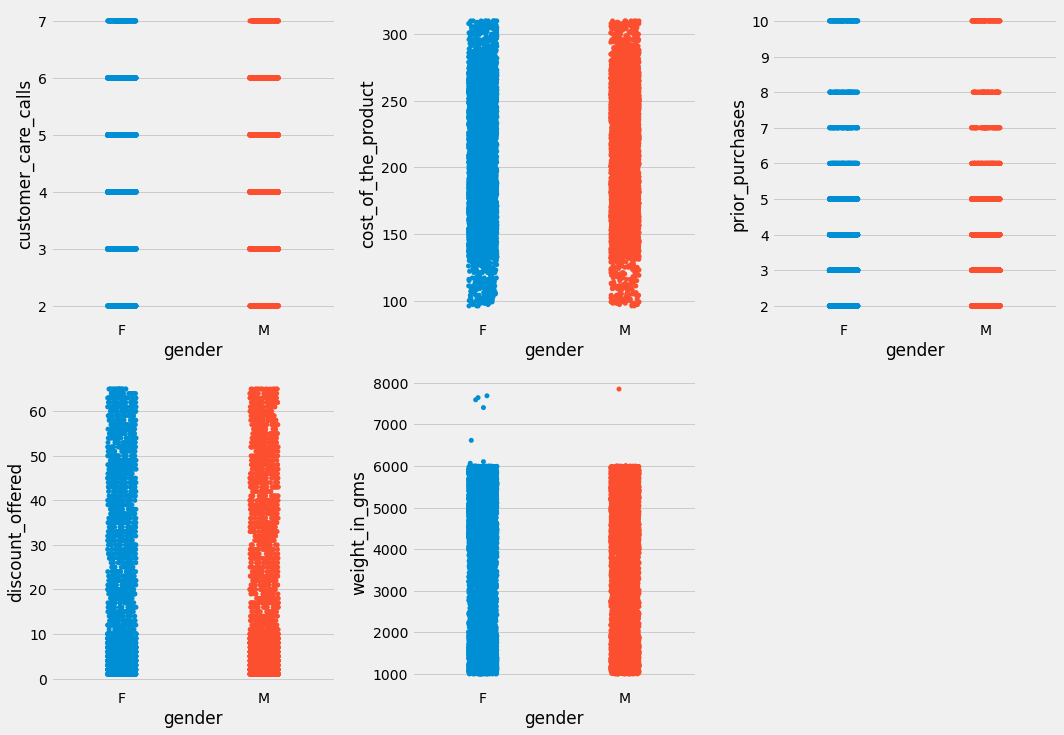

In [34]:
# Numeric - Gender
fig = plt.figure(figsize=(15, 15))
for i in range(0, len(numeric)): # untuk setiap kolom numerik
    ax = fig.add_subplot(3, 3, i+1) # kita set posisi catplot/stripplotnya di layout
    sns.stripplot(ax=ax, data=df_eda, x='gender', y=numeric[i]) # gambar catplot/stripplotnya
    plt.tight_layout() # layout

    if i != 0: plt.close(i+1) # close figure 

    plt.close(len(numeric) + 1) # close figure 

* Summary :

gender doesn't seem to have a correlation with the target.

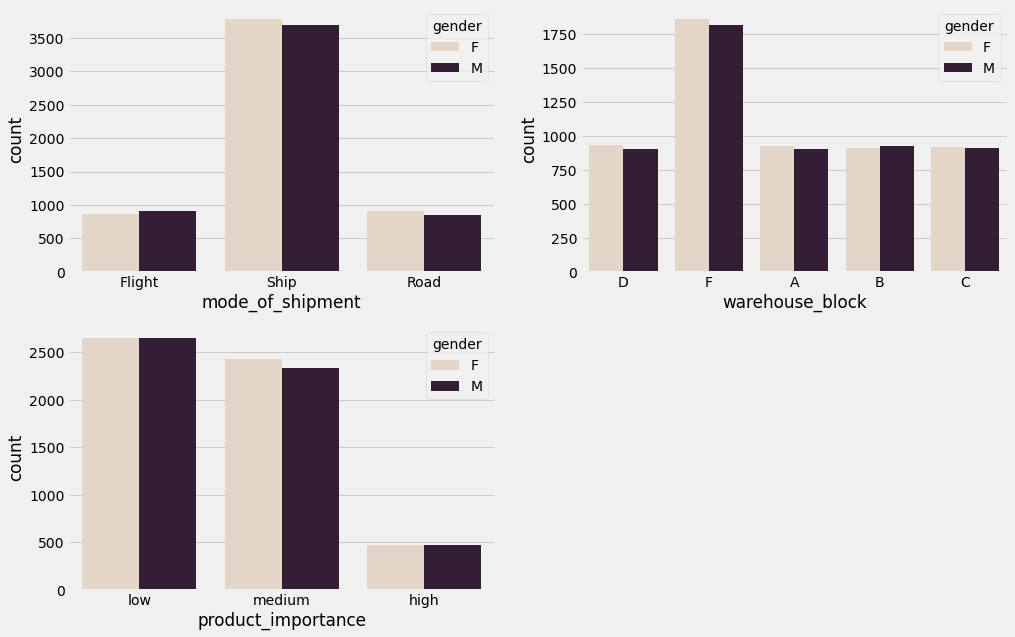

In [36]:
# Categorical - Categorical
# Based on Gender
i=1
plt.figure(figsize=(15,10))
for col in ['mode_of_shipment', 'warehouse_block', 'product_importance']:
    plt.subplot(2,2,i)
    sns.countplot(df_eda[col], hue=df_eda['gender'], palette="ch:.25")
    i+=1

* Summary :

Total parcels of female customers in the warehouse_block are more dominant than male customers, except in warehouse_block B.

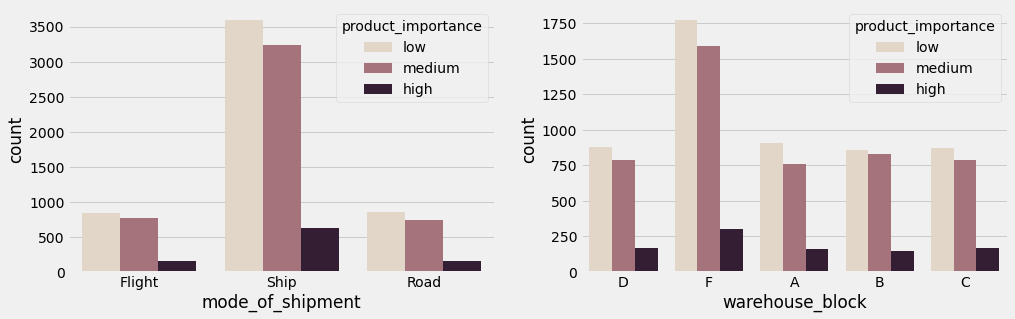

In [37]:
# Based on Product Importance
i=1
plt.figure(figsize=(15,10))
for col in ['mode_of_shipment', 'warehouse_block']:
    plt.subplot(2,2,i)
    sns.countplot(df_eda[col], hue=df_eda['product_importance'], palette="ch:.25")
    i+=1

* Summary :

Mostly high & low priority parcels used ship.

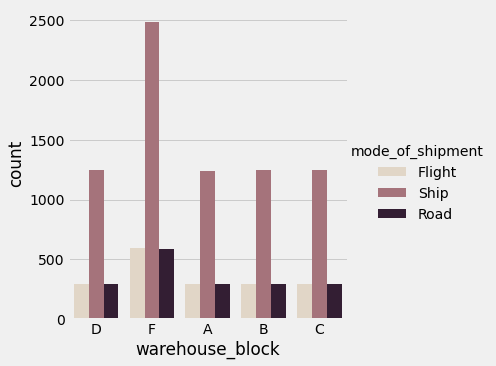

In [39]:
# Warehouse block - Mode of Shipment
sns.catplot(x="warehouse_block", kind="count", hue='mode_of_shipment',
            palette="ch:.25", data=df_eda);

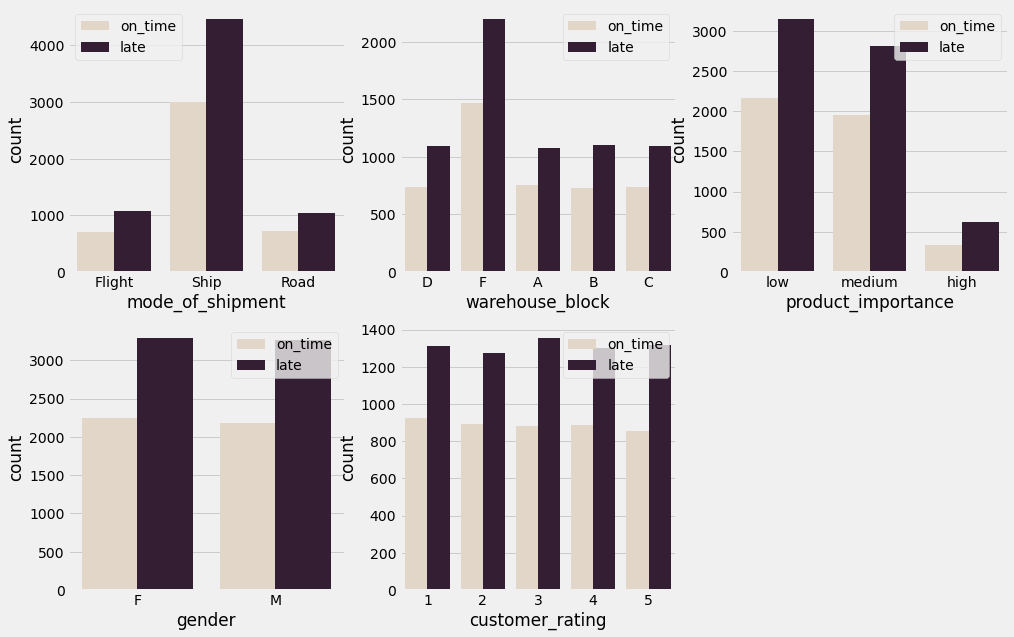

In [40]:
#Based on target 'is_late'
i=1
plt.figure(figsize=(15,10))
for col in ['mode_of_shipment', 'warehouse_block', 'product_importance',
            'gender','customer_rating']:
    plt.subplot(2,3,i)
    sns.countplot(df_eda[col], hue=df_eda['is_late'], palette="ch:.25")
    i+=1
    plt.legend(['on_time','late']);

* Summary :

1. Most of parcels are stored in warehouse_block F.
2. The ship contributes the most late delivery.
3. Most of parcels in all shipment priority are delivered late.